In [1]:
import importlib
imported_module = importlib.import_module("function_library")
importlib.reload(imported_module)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


<module 'function_library' from '/Users/hadiwidjajastella/Documents/MEng/floating/development/Stella-Hadiwidjaja/floating/function_library.py'>

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import pvlib
import pickle
import numpy as np
import seaborn as sns
import function_library as fl
import rdtools
import statsmodels.api as sm

# Performance Ratio of Tengeh Floating Solar PV Testbed

The examination of a PV system's Performance Loss Ratio (PLR) is crucial for gauging its durability and, consequently, its suitability as a commercial product. The calculation of PLR is not a uniform process, given the highly variable nature of PV datasets. However, a review of existing literature reveals the presence of a recommended framework to promote transparency and effective communication within this domain, and this framework will guide the process outlined in this notebook.

This notebook presents the step-by-step procedure for computing PLR for the Tengeh Floating Solar PV Testbed. The process commences with the temporal integration of the raw dataset, organized by system and sensor type, and culminates in the determination of the annual degradation rate. The primary objectives of this notebook are 

1. to clarify and visualise the quality of the original dataset, 
2. thoroughly elucidate the steps taken during the process
3. discuss the considerations underlying the decisions made during the analysis
4. systematically compute the PLR for the Tengeh floating solar system.

# Table of Contents

1. [Initialisation](#chap_initialisation)
2. [Irradiance](#chap_irradiance)
    1. Data availability
    2. Data quality assessment and grading
    3. Data filtering
    4. Data choice (TBC)
    5. Data imputation (TBC)
        1. Internal imputation
        2. Marina barrage imputation
    6. Clear sky conditions
4. [Temperature](#chap_temperature)
    1. Data availability
    2. Data quality assessment and grading
    3. Data filtering
3. [Power](#chap_power)
    1. Data availability
    2. Data quality assessment and grading
    3. Data filtering
    4. Temperature correction (TBC)
5. [Performance Ratio (PR)](#chap_PR)
    1. Normal Calculation
    2. Temperature Corrected Calculation
6. [Degradation](#chap_degradation)
    1. Regression
    2. YoY
    3. Confidence intervals


*Nomenclature*:\
    - **System** refers to a collection of PV strings of the same type. In the Tengeh testbed, there are a total of 10 different systems tested, each with a different combination of panel brand, power rating, and flotation, for example: 'REC','SSACl'.\
    - **Sensor Type** refers to the parameter a sensor is measuring, for example: 'Gmod' refers to global irradiance, 'Pdc' refers to DC power output.  \
    - **Sensor Station** refers to a group of sensors whose data is collected together. This data has already been split into the respective system and sensor type in a previous script. The sensor stations are the following:



# Initialisation  <a class="anchor" id="chap_initialisation"></a>

This step loads all the related parameters needed for the analyis, including:

1. Location 
2. Time Range of Dataset
3. Time Range of Dataset during sunlight hours
4. System specification
5. Sensors

*Location*

In [3]:
# Location of Tengeh floating PV testbed
latitude = 1.349578
longitude = 103.639491
timezone = 'Asia/Singapore'
tengeh = pvlib.location.Location(latitude,longitude, altitude=0, tz=timezone)

*Time Range of Dataset*

In [4]:
# Fix time period, time resolution and timezone
start_date = '2017-01-01'
end_date = '2023-04-30'
freq = 'T' # minute resolution


# create time index with minute resolution during full timespan
all_minutes =  pd.date_range(start=start_date, end=end_date, freq=freq, tz=timezone)

*Time Range of Dataset during Sunlight Hours*

Generally, night time is not considered in PV analysis. Furthermore, previous analyses has shown that the periods of sunrise and sunset when the sun is close to the horizon has problematic effects on irradiance sensors due to reflectance (Luo, 2020). Thus, this study chooses to only include irradiance data from when the sun's altitude is higher than 15 degrees, and this angle is customisable.

In [5]:
# create time index with only time from after sunrise and before sunset 
sun_minutes = fl.create_timestamps(start_date,end_date,latitude= latitude,longitude=longitude ,timezone=timezone,freq=freq,solar_angle_cutoff = 15)

*System Specifications*

The floating testbed consists of several systems of several strings each, with different modules and arrangements. The details are stored in python dictionaries and loaded below.

In [6]:
# Load specifications of systems, pre-defined in a python dictionary
fp_pickles = '/Users/hadiwidjajastella/Documents/MEng/floating/version_3/pickles/'

# load system specs from dictionary 
with open(fp_pickles+'no_of_panels.pickle', 'rb') as f:
    no_of_panels_d = pickle.load(f)

with open(fp_pickles+'module_name.pickle', 'rb') as f:
    module_name_d = pickle.load(f)
    
with open(fp_pickles+'module_Wp.pickle', 'rb') as f:
    module_Wp_d = pickle.load(f)

*Sensors*

Each sensor's data belongs to a station, which collectively stores data. The sensor_dict dictionary contains each group that the sensor belongs to.

Sensor Stations:
- 128:	Irradiance signals reaching solar panels and weather signals from sensors located near the water 
- 130:	Module temperature
- 132:	Irradiance signals reaching solar panels and module temperature
- 134:	Weather signals on shore
- 135:	DC electrical signals from FPV strings
- 136:	DC electrical signals from FPV strings

In [7]:
#dictionary containing sensor parameters and their stations
dict_fp = '/Users/hadiwidjajastella/Documents/MEng/floating/version_1_11-5/post_recessweek/'
dict_fp_sensor_station = dict_fp+'sensor_station.pickle'

with open(dict_fp_sensor_station, 'rb') as f:
    sensor_dict = pickle.load(f)

In [8]:
# Load list of all sensors
sensor_list_all = pd.read_csv('/Users/hadiwidjajastella/Documents/MEng/floating/sensor_list.csv')
sensor_list_all = sensor_list_all['Feature Name'].tolist()
sensor_list_all

['AvgGmod07_SGNRG',
 'AvgTSi07_SGNRG',
 'AvgTmod1s1_SGNRG',
 'AvgTmod1s2_SGNRG',
 'AvgGmod07_SG4CS',
 'AvgTSi07_SG4CS',
 'AvgTmod1s3_SG4CS',
 'AvgTmod1s4_SG4CS',
 'AvgGmod05_UpS',
 'AvgTSi05_UpS',
 'AvgTmod6s1_UpS',
 'AvgTmod6s2_UpS',
 'AvgTmod6s3_UpS',
 'AvgGSi00_OffS',
 'AvgGHIUp_OffS',
 'AvgGHIDn_OffS',
 'AvgAlbedo_OffS',
 'AvgGuv_OffS',
 'AvgWindS_OffS',
 'AvgWindD_OffS',
 'AvgAirP_OffS',
 'AvgHamb_OffS',
 'AvgTSi00_OffS',
 'AvgTamb_OffS',
 'short_up',
 'short_dn',
 'long_up',
 'long_dn',
 'long_up_core',
 'long_dn_corr',
 'Rs_net',
 'Rl_net',
 'albedo',
 'Rn',
 'cnr4_T_C',
 'short_up_2',
 'short_dn_2',
 'long_up_2',
 'long_dn_2',
 'long_up_corr_2',
 'long_dn_corr_2',
 'Rs_net_2',
 'Rl_net_2',
 'albedo_2',
 'Rn_2',
 'cnr4_T_C_2',
 'AvgGmod12E_PS',
 'AvgGmod12W_PS',
 'AvgTSi12E_PS',
 'AvgTSi12W_PS',
 'AvgTmod2s1_PS',
 'AvgTmod2s2_PS',
 'AvgTmod2s3_PS',
 'AvgTmod2s4_PS',
 'AvgTmod3s1_SS',
 'AvgTmod3s2_SS',
 'AvgTmod3s3_SS',
 'AvgGmod12_SS',
 'AvgTSi12_SS',
 'AvgGmod07_REC',
 'AvgTSi0

*Filepaths to load and save files*

In [9]:
#filepath to files merged temporally
fp_load = '/Users/hadiwidjajastella/Documents/MEng/floating/version_3/merged/'

#filepath to figure folder (for saving)
fp_fig = '/Users/hadiwidjajastella/Documents/MEng/floating/version_4/'

*Filter Range*
The lower and upper bounds of each parameter measured by the sensor, which will be used to filter out erroneous data.

In [10]:
#filter range dictionary
range_dict = {'Tamb':[10,50],'Hamb':[0,100],'Wind':[0,30],'Gmod':[100,1200],'Pdc':[50,6000],'Tmod':[10,100]}

# Irradiance  <a class="anchor" id="chap_irradiance"></a>


Despite being commonly characterized as a sunny tropical island, Singapore's climate exhibits high variability due to factors such as cloud cover and rainfall. Within the testbed, two types of silicon sensors are utilized: Silicon (Si) sensors and SPN1 sensors. Each system is paired with its own Si sensor, and the testbed is equipped with an SPN1 sensor both onshore and offshore. This section focuses on the assessment and preparation of irradiance data to facilitate the calculation of the Performance Loss Ratio (PLR).

*Loading Irradiance Data*

In [11]:
# find all sensors measuring irradiance, with keywords 'Gmod','GHI','SPN'
sensor_list = fl.filter_sensors_by_terms(sensor_list_all, ['Gmod'])
sensor_list = sensor_list+fl.filter_sensors_by_terms(sensor_list_all, ['GHI'])
sensor_list = sensor_list+fl.filter_sensors_by_terms(sensor_list_all, ['SPN'])

There are three main types of irradiance data: 
1. 'Gmod' : Global irradiance at low POA angles for each system, W:West E:East.
2. 'GHI' : Global Horizontal Irradiance of Up,Down direction offshore and onshore from Si sensor.
3. 'SPN1G/D' : Global Horizontal Irradiance of Up,Down direction onshore from SPN sensor.

In [12]:
# Creating dataframe with irradiance values
df_irradiance = fl.generate_sensor_csv(sensor_list,fp_load, sensor_dict,sun_minutes,csv_suffix = '_day_merged.csv')

## Irradiance: Data Quality

Following the framework set by (Lindig et al., 2021, p. 578), the quality of the available irradiance data is graded using the following criteria:

<img src="notebook_figs/table_grading.png" width = 500>
(Table columns in green taken from Lindig et al., 2021, p. 578)

A grade for anomalous data is introduced, relying on Lindig's definition of irradiance filters (ranging from 100W/m2 to 1200W/m2), beyond which the data is considered anomalous. This grade provides insight into the extent of data that will be excluded during the filtering process. 
Note that the cutoff time is already positioned after sunrise and sunset, mitigating the need to filter low irradiance values (0W/m2-100W/m2).

*Grading Data*

In [13]:
# Create df to store results of data quality grading
results_df_irradiance = pd.DataFrame(columns = ['sensor','Outliers (%)','Outliers (%) grade','Missing Percentage (%)','Missing Percentage (%) grade','Longest gap (days)','Longest gap (days) grade','Anomalies (%)','Anomalies (%) grade','Length (days)','Length (days) grade','Grades'])
results_df_irradiance['sensor']=sensor_list
results_df_irradiance.set_index('sensor',inplace=True)

In [14]:
# grade results
results_df_irradiance['Missing Percentage (%)'], results_df_irradiance['Missing Percentage (%) grade'] = fl.calculate_missing_percentage_grade(df_irradiance)
results_df_irradiance['Longest gap (days)'], results_df_irradiance['Longest gap (days) grade']= fl.calculate_longest_gap_grade(df_irradiance)
results_df_irradiance['Outliers (%)'],results_df_irradiance['Outliers (%) grade']=fl.calculate_outliers_grade(df_irradiance)
results_df_irradiance['Anomalies (%)'],results_df_irradiance['Anomalies (%) grade']=fl.calculate_anomalies_grade(df_irradiance,range_dict['Gmod'])
results_df_irradiance['Length (days)'],results_df_irradiance['Length (days) grade']=fl.calculate_time_difference_grade(df_irradiance)
results_df_irradiance['Grades'] = results_df_irradiance[['Outliers (%) grade', 'Missing Percentage (%) grade',
                                                                      'Longest gap (days) grade', 'Anomalies (%) grade','Length (days) grade']].apply(lambda x: ''.join(x), axis=1)
# grading criteria does not apply for reflected or diffuse light (GHIDn), so remove
results_df_irradiance = results_df_irradiance[~results_df_irradiance.index.str.contains('Dn')]
results_df_irradiance = results_df_irradiance[~results_df_irradiance.index.str.contains('SPN1D')]

# see results
results_df_irradiance

,Outliers (%),Outliers (%) grade,Missing Percentage (%),Missing Percentage (%) grade,Longest gap (days),Longest gap (days) grade,Anomalies (%),Anomalies (%) grade,Length (days),Length (days) grade,Grades
sensor,,,,,,,,,,,
AvgGmod07_SGNRG,0.04,A,27.45,C,81,C,17.56,B,2094,P,ACCBP
AvgGmod07_SG4CS,0.00,A,27.45,C,81,C,17.09,B,2094,P,ACCBP
AvgGmod05_UpS,0.00,A,27.45,C,81,C,16.98,B,2094,P,ACCBP
AvgGmod12E_PS,0.00,A,31.61,C,282,D,8.96,A,1606,P,ACDAP
AvgGmod12W_PS,1.13,A,31.61,C,282,D,11.05,B,1606,P,ACDBP
AvgGmod12_SS,0.00,A,31.61,C,282,D,11.96,B,1606,P,ACDBP
AvgGmod07_REC,0.01,A,31.61,C,282,D,23.53,B,1606,P,ACDBP
AvgGmod10_Shp,0.00,A,31.61,C,282,D,8.64,A,1606,P,ACDAP
AvgGmod12_SSACl,0.05,A,31.43,C,282,D,17.17,B,1608,P,ACDBP


*Data Quality: Temporal Data Visualisation* \
To get a feel of the missing and anomalous data's temporal trends, the data is visualised per month.

In [15]:

# Resample the data by month
monthly_data = df_irradiance.resample('M')

# Calculate the percentage of NaN data for each month and sensor
nan_percentages = monthly_data.apply(lambda x: (x.isnull().mean() * 100).mean())

# Calculate the percentage of anomalous data for each month and sensor
anomalous_percentages = monthly_data.apply(lambda x: ((x < 100) | (x > 1200)).mean() * 100)

# Create DataFrames with sensors as rows and months as columns
nan_percentages.index = nan_percentages.index.strftime('%b %Y')
anomalous_percentages.index = anomalous_percentages.index.strftime('%b %Y')

nan_df = nan_percentages.T
anomalous_df = anomalous_percentages.T


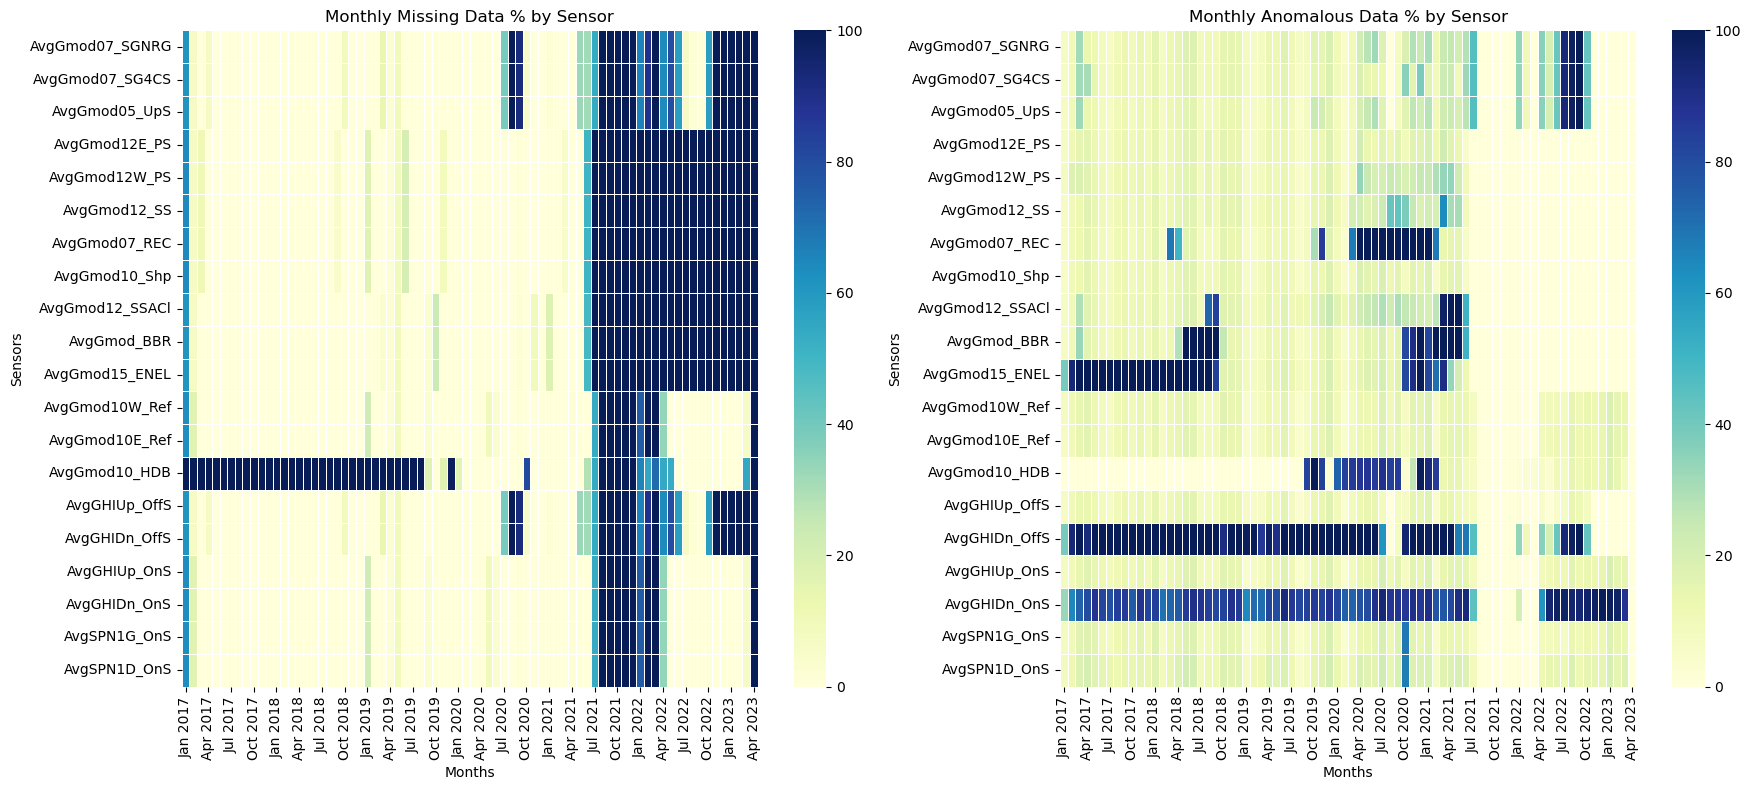

In [16]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# First subplot for NaN percentages
sns.heatmap(nan_df, cmap="YlGnBu", annot=False, fmt=".2f", linewidths=.5, ax=axes[0])
axes[0].set_title('Monthly Missing Data % by Sensor')
axes[0].set_xlabel('Months')
axes[0].set_ylabel('Sensors')

# Second subplot for anomalous percentages
sns.heatmap(anomalous_df, cmap="YlGnBu", annot=False, fmt=".2f", linewidths=.5, ax=axes[1])
axes[1].set_title('Monthly Anomalous Data % by Sensor')
axes[1].set_xlabel('Months')
axes[1].set_ylabel('Sensors')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()



The visual inspection of the graphs the occasional existence of missing or anomalous data in the irradiance sensors, suggesting the need for data filtering and internal imputation techniques. Notably, a critical issue identified is the occurrence of a testbed-wide data gap in the late 2021 to early 2022 period, necessitating external imputation methods.

Note that GHIDn can be ignored as it measuring reflected irradiance.

## Irradiance Filtering
Three main filters is used in filtering data, which will be used for irradiance, power and temperature:

1. **Range Filter** Filters out anomalous data that is smaller than 100W/m2 and larger than 1200W/m2. The cutoffs can be defined in the variable range_dict.

2. **NaN by percentage filter** This filter is employed to eliminate time aggregates that exhibit a disproportionately high percentage of NaN data. The purpose is to ensure that, during subsequent aggregations in the pipeline, these data points do not become anomalous and cause data skew. Because the PR will be calculated monthly, we are going to have monthly aggregates.

3. **Bins filter** Certain sensors may exhibit errors causing them to register a semi-constant or constant value for extended periods. These persistent errors become discernible when the data is binned into a histogram. By excluding these specific bins, we can effectively eliminate this type of error from the dataset. The bins must be adequately small to not disturb naturally-occuring values that are not errors.

In [17]:
#apply filters

df_irradiance_filtered= df_irradiance.copy()

# Take out anomalous data
df_irradiance_filtered = fl.filter_range(df_irradiance_filtered,range_dict['Gmod'], columns=None)

# Take out abnormal bins - recurring semi-constant erros
df_irradiance_filtered = fl.filter_abnormal_bins(df_irradiance_filtered)

# Take out any months where there is more than 70% NaN data
df_irradiance_filtered = fl.filter_by_nan_percentage(df_irradiance_filtered, freq='M',threshold=0.7)

# Take out any days where there is more than 70% NaN data
df_irradiance_filtered = fl.filter_by_nan_percentage(df_irradiance_filtered, freq='D',threshold=0.7)


Number of Deleted Bins:0
Number of Deleted Bins:0
Number of Deleted Bins:0
Number of Deleted Bins:0
Number of Deleted Bins:0
Number of Deleted Bins:0
Number of Deleted Bins:0
Number of Deleted Bins:0
Number of Deleted Bins:0
Number of Deleted Bins:0
Number of Deleted Bins:0
Number of Deleted Bins:0
Number of Deleted Bins:0
Number of Deleted Bins:0
Number of Deleted Bins:0
Number of Deleted Bins:0
Number of Deleted Bins:0
Number of Deleted Bins:0
Number of Deleted Bins:0
Number of Deleted Bins:0


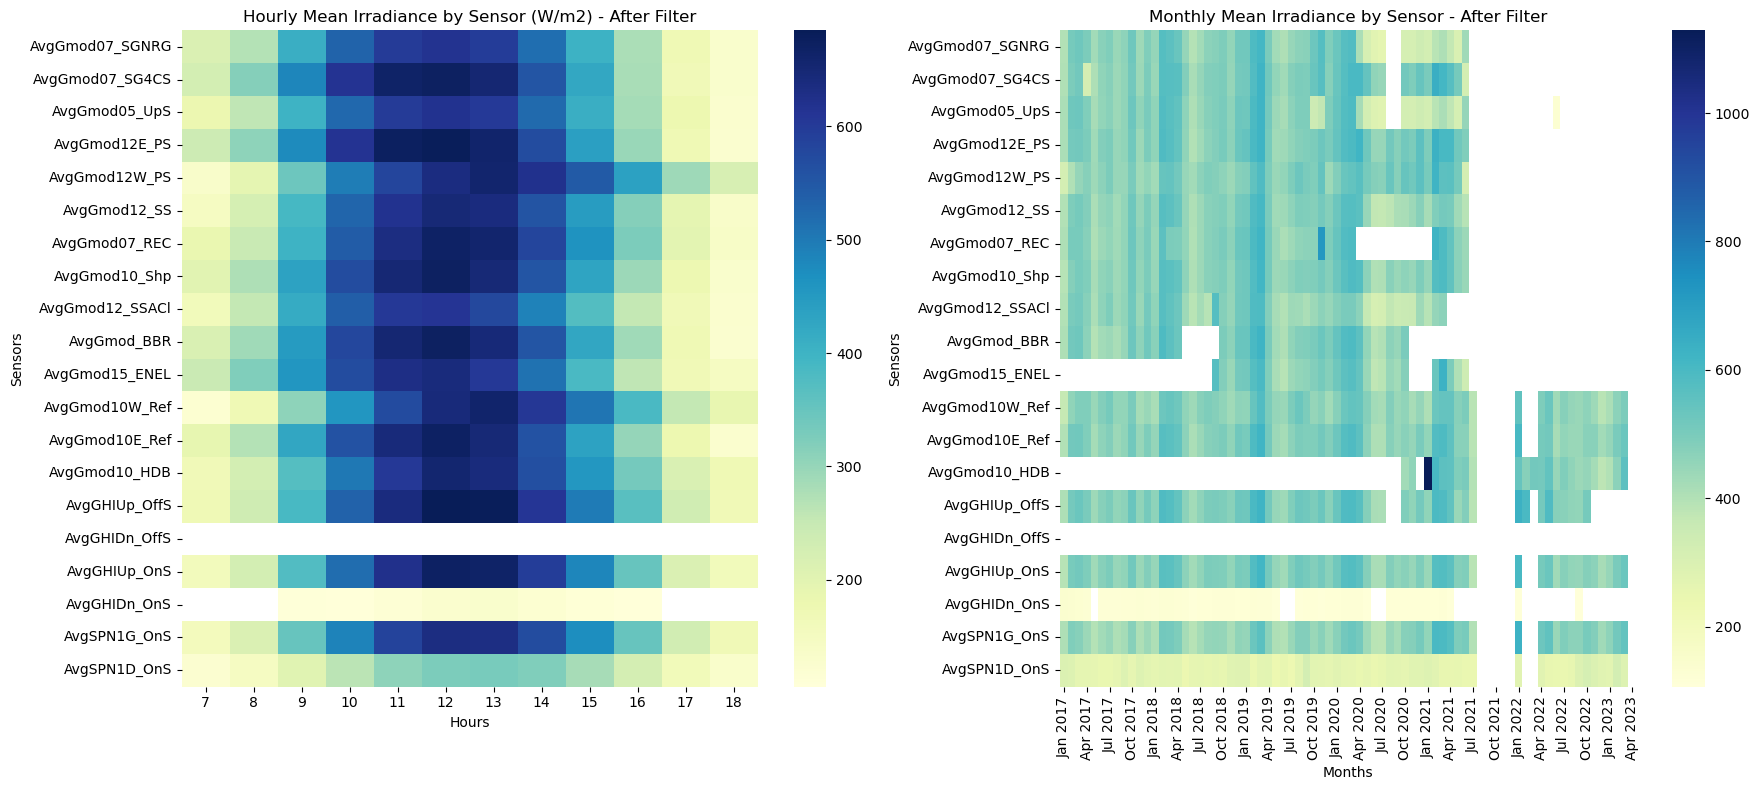

In [18]:
# Create the first heatmap for hourly mean
hourly_mean_df = df_irradiance_filtered.groupby(df_irradiance_filtered.index.hour).mean()

# Create the second heatmap for monthly mean
monthly_mean_df = df_irradiance_filtered.resample('M').mean()
monthly_mean_df.index = monthly_mean_df.index.strftime('%b %Y')

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# First subplot for hourly mean
sns.heatmap(hourly_mean_df.T, cmap="YlGnBu", annot=False, ax=axes[0])
axes[0].set_title('Hourly Mean Irradiance by Sensor (W/m2) - After Filter')
axes[0].set_xlabel('Hours')
axes[0].set_ylabel('Sensors')

# Second subplot for monthly mean
sns.heatmap(monthly_mean_df.T, cmap="YlGnBu", annot=False, ax=axes[1])
axes[1].set_title('Monthly Mean Irradiance by Sensor - After Filter')
axes[1].set_xlabel('Months')
axes[1].set_ylabel('Sensors')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

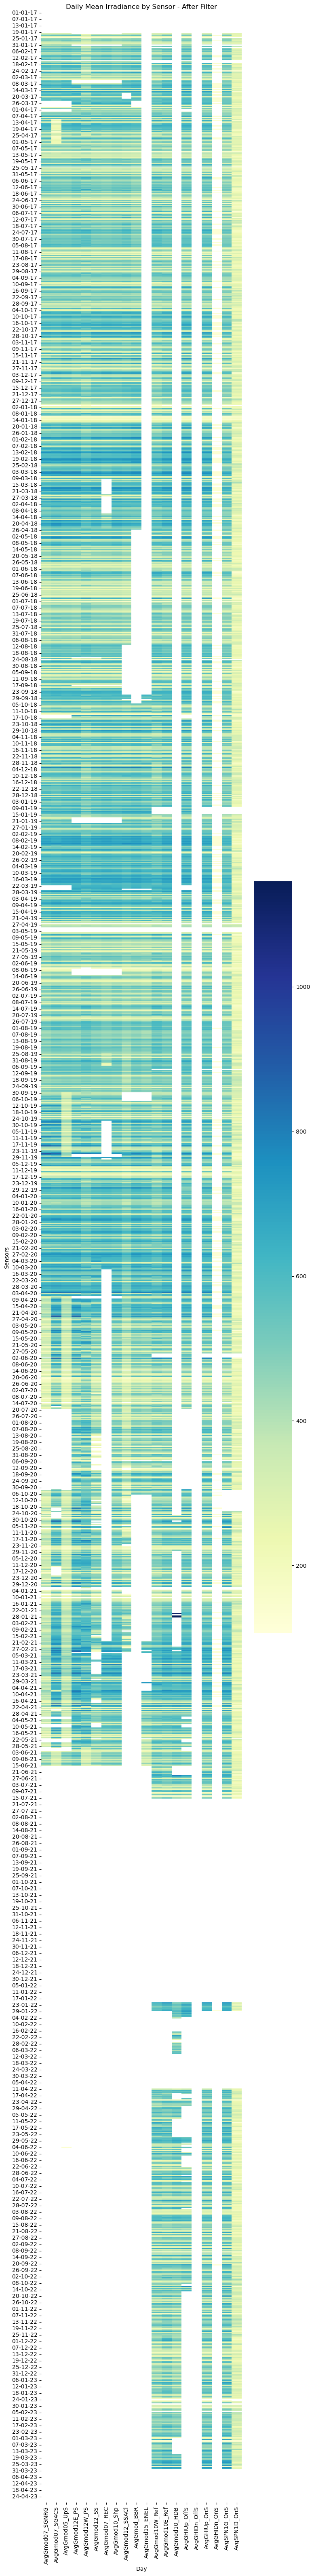

In [19]:
# Create the heatmap for daily mean
daily_mean_df = df_irradiance_filtered.resample('D').mean()
daily_mean_df.index = daily_mean_df.index.strftime('%d-%m-%y')
plt.figure(figsize=(8,80))
sns.heatmap(daily_mean_df, cmap="YlGnBu", annot=False)
plt.title('Daily Mean Irradiance by Sensor - After Filter')
plt.xlabel('Day')
plt.ylabel('Sensors')
plt.show()

Some processing and imputation is required due to missing data. The final dataset used for further calculation is:


In [20]:
fp_Gmod = '//Users/hadiwidjajastella/Documents/MEng/floating/version_4/Gmod_imputed.csv'
df_Gmod = pd.read_csv(fp_Gmod,index_col = 0, parse_dates = True).drop(columns=['Location'])
df_Gmod.set_index(sun_minutes,inplace=True)
gmod_col = 'Gmod'
df_Gmod_calc = df_Gmod[gmod_col]

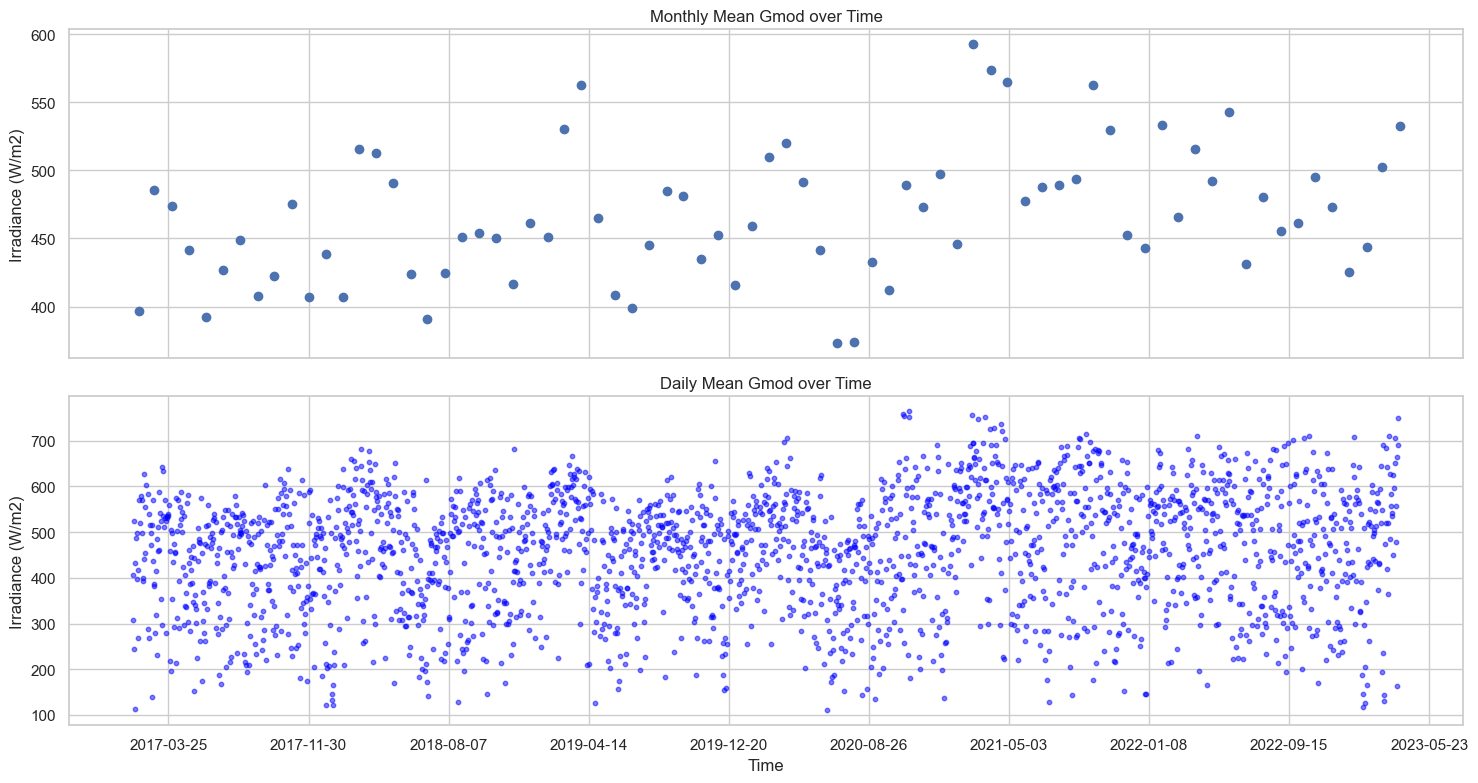

In [21]:
#Visualise data

# Resample data for monthly and daily means
monthly_means = df_Gmod_calc.resample('M').mean()
daily_means = df_Gmod_calc.resample('D').mean()

# Set Seaborn style
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

# Plot monthly means
axes[0].scatter(monthly_means.index, monthly_means, marker='o')
axes[0].set_ylabel('Irradiance (W/m2)')
axes[0].set_title('Monthly Mean Gmod over Time')

# Add x-axis ticks for daily means
axes[0].xaxis.set_major_locator(plt.MaxNLocator(nbins=10))
axes[0].xaxis.set_minor_locator(plt.MaxNLocator(nbins=100))

# Plot daily means
scatter = axes[1].scatter(daily_means.index, daily_means, s=10, c='blue', marker='o', alpha=0.5)
axes[1].set_ylabel('Irradiance (W/m2)')
axes[1].set_title('Daily Mean Gmod over Time')

# Add x-axis label
axes[-1].set_xlabel('Time')

# Add x-axis ticks for daily means
axes[-1].xaxis.set_major_locator(plt.MaxNLocator(nbins=10))
axes[-1].xaxis.set_minor_locator(plt.MaxNLocator(nbins=100))

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


# Clear Sky Conditions

Certain PR calculations prioritize utilizing data from clear sky conditions, as it provides a more accurate reflection of the degradation state of the PV panel without interference from factors such as shading and cloud cover. In this notebook, we will be conducting calculations for both normal (full) and clear sky conditions for comparative purposes.


The algorithm to find clearsky condition can be found in the pvlib library, introduced in the paper "Identification of periods of clear sky irradiance in time series of GHI measurements" by Matthew J. Reno, Clifford W. Hansen (2016).

In [22]:
# clear sky model requires timestamps with no time skip
dates_range = pd.date_range(start=start_date, end=end_date, freq=freq, tz=timezone)
df_Gmod_clearsky = pd.DataFrame(index=dates_range)

# localise index of Gmod
df_Gmod.set_index(sun_minutes.tz_localize('Asia/Singapore'),inplace=True)

# create df with both clear sky model and measured irradiance
df_Gmod_clearsky = df_Gmod_clearsky.join(df_Gmod['Gmod'], how='left')
df_Gmod_clearsky['clear_sky'] = tengeh.get_clearsky(dates_range)['ghi']

In [23]:
# detect clear sky conditions w pvlib algorithm
clear_samples = pvlib.clearsky.detect_clearsky(df_Gmod_clearsky['Gmod'],df_Gmod_clearsky['clear_sky'])

Visualising the results of the algorithm, it seems that Singapore is not the clearest-sky place to be.

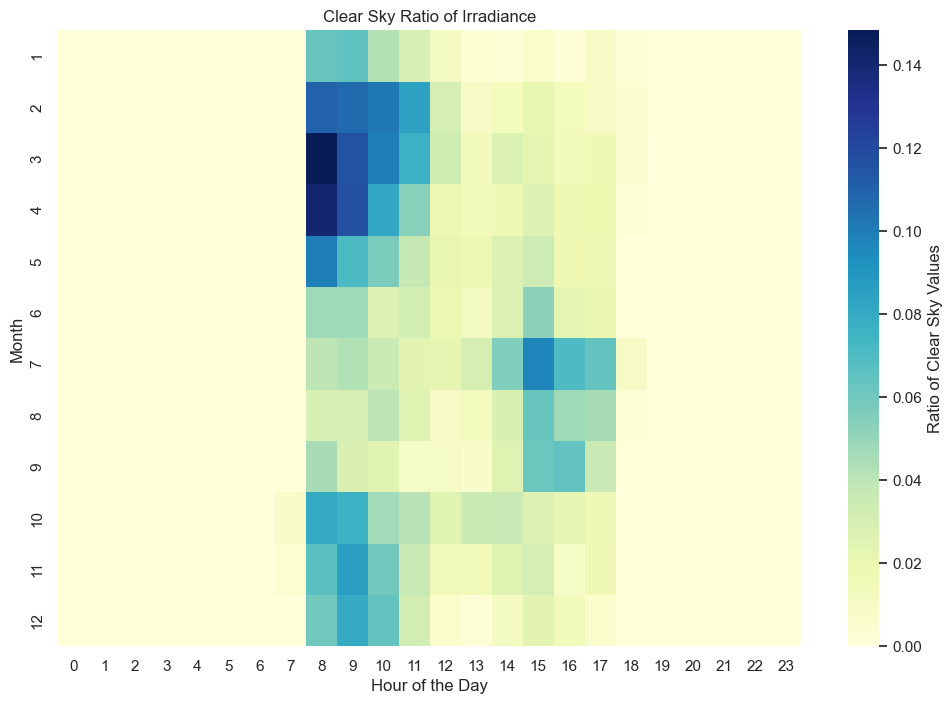

In [24]:
df_plot = pd.DataFrame({
    'Gmod':df_Gmod_clearsky['Gmod'],
    'clear_sky':df_Gmod_clearsky['clear_sky'],
    'clear_sample': clear_samples,
    'month': dates_range.month,
    'hour': dates_range.hour
})

# Group by month and hour, count True values, and reshape the data for heatmap
heatmap_data = df_plot['clear_sample'].groupby([df_plot['month'],df_plot['hour']]).mean().unstack()


# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=False, fmt='g', cbar_kws={'label':'Ratio of Clear Sky Values'})
plt.title('Clear Sky Ratio of Irradiance')
plt.xlabel('Hour of the Day')
plt.ylabel('Month')
plt.show()


While Singapore may not exhibit traditional 'seasons,' its climate features two distinct monsoon seasons interspersed with inter-monsoonal periods. The Northeast Monsoon prevails from December to early March, while the Southwest Monsoon dominates from June to September. Let's visualize the outcomes of the clear-sky algorithm during these four periods over the course of a single day.

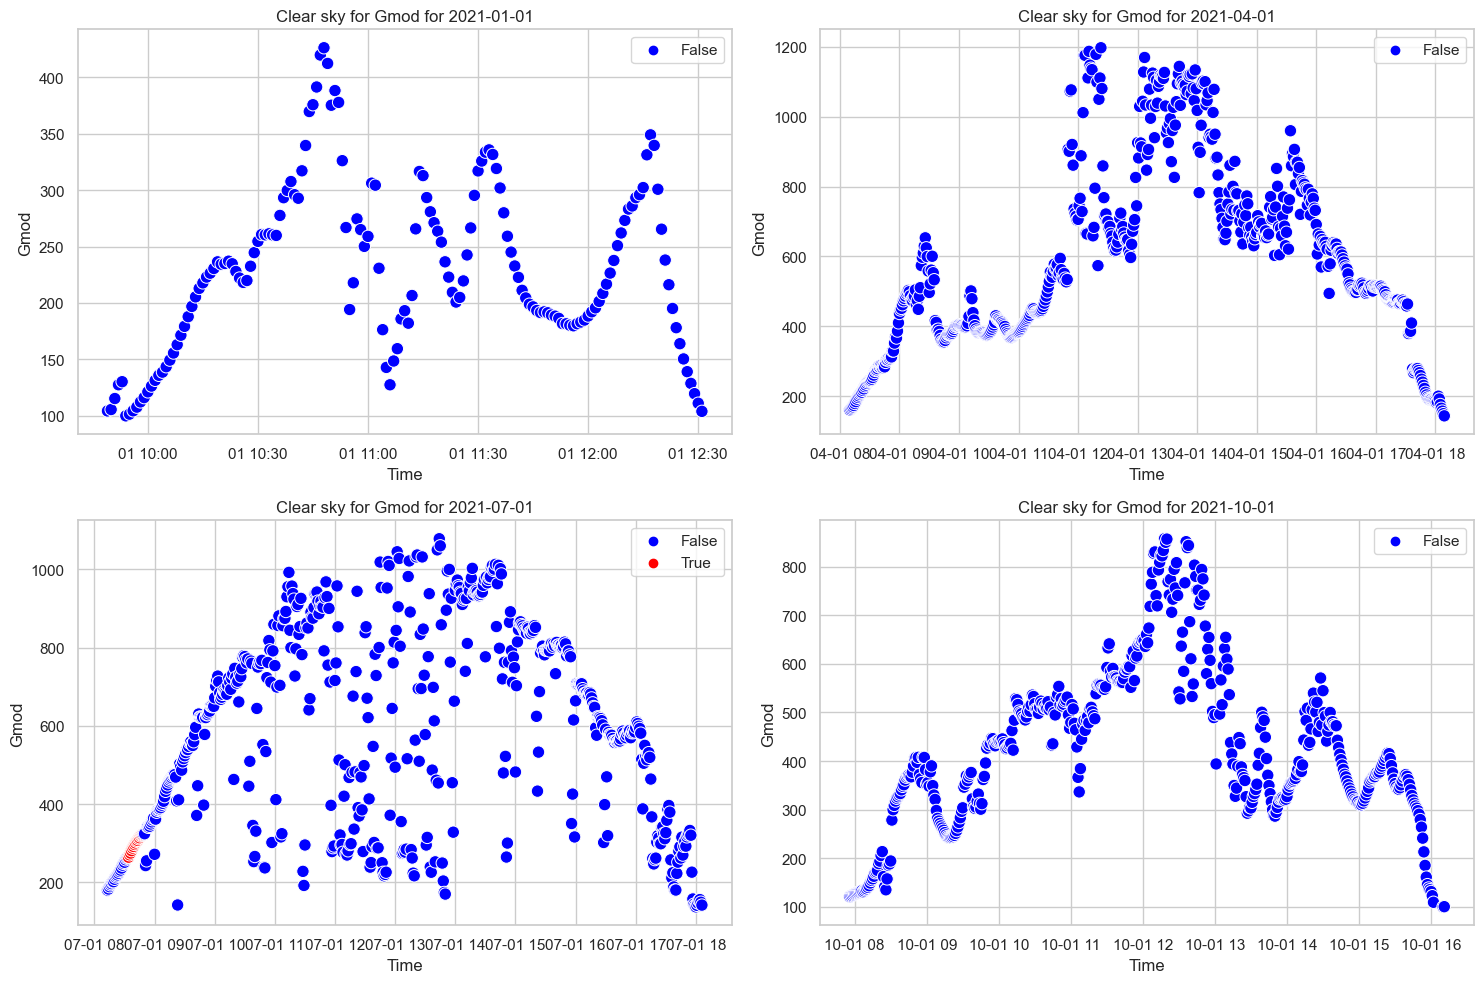

In [25]:
year = '2021'
selected_days = [year+'-01-01', year+'-04-01', year+'-07-01', year+'-10-01']

# Set Seaborn style
sns.set(style="whitegrid")

# Create a 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Flatten the 2x2 grid for easier iteration
axes = axes.flatten()

for i, selected_day in enumerate(selected_days):
    selected_data = df_plot[df_plot.index.date == pd.to_datetime(selected_day).date()]

    # Create a scatter plot with Seaborn in the current subplot
    scatter = sns.scatterplot(ax=axes[i], x=selected_data.index, y=selected_data['Gmod'],
                              hue=selected_data['clear_sample'], palette={True: 'red', False: 'blue'}, s=80)

    # Add labels and title
    axes[i].set_title(f'Clear sky for Gmod for {selected_day}')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Gmod')

    # Customize legend
    handles, labels = scatter.get_legend_handles_labels()
    axes[i].legend(handles, ['False', 'True'])

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


The clear sky algorithm doesn't work very well for Singapore's very cloudy and intermittent climate. So, let's consider a simple 800W to 1200W filter and consider that the clear sky data...(Lindig et al., 2021, p. 578). 

In [26]:
# Create df_Gmod_clear_sky_calc by filtering values above 800
df_Gmod_clear_sky_calc = df_Gmod_calc[df_Gmod_calc > 800]

# Create clear_sky_date_range with dates where df_Gmod_clear_sky_calc is not NaN
clear_sky_date_range = df_Gmod_clear_sky_calc.dropna().index

# Measure data loss
total_values = df_Gmod_calc.count().sum()
total_values

total_new_values = df_Gmod_clear_sky_calc.count().sum()
total_new_values

percentage_clearsky=(total_new_values/total_values)

print(f'Ratio of Clear Sky to Full Data Size: {percentage_clearsky:.2f}')


Ratio of Clear Sky to Full Data Size: 0.16


## Irradiance: Filtering

 In dealing with time-series data, particularly outdoor PV time series data, there are numerous filter options available in the literature. However, based on a comprehensive literature review and considerations of the specific data deficiencies uncovered during our dataset exploration, three filters have been implemented in this work. These filters are chosen to strike a balance between effectiveness and simplicity, aiming to optimize the quality of the output while minimizing complexity in the processing pipeline.
 
 1. **Range Filter** This is a standard filter designed to eliminate non-physical data points that are evidently erroneous. The filter range is determined based on the guidelines provided by XXX (cite reference) and general observations across the entire dataset.
<img src="notebook_figs/range_filter.png" width = 600>
2. **NaN by percentage filter** This filter is employed to eliminate time aggregates (with the default being daily aggregates) that exhibit a disproportionately high percentage of NaN data. The purpose is to ensure that, during subsequent aggregations in the pipeline, these data points do not become anomalous and cause data skew.


3. **Bins filter** Certain sensors may exhibit errors causing them to register a semi-constant or constant value for extended periods. These persistent errors become discernible when the data is binned into a histogram. By excluding these specific bins, we can effectively eliminate this type of error from the dataset. The bins must be adequately small to not disturb naturally-occuring values that are not errors.


<img src="notebook_figs/semi_constant_error.png">
<img src="notebook_figs/bin_filter_results.png" width =400 height=140 />

The 'type' of sensor in our dataset corresponds to the parameter being measured, such as 'Pdc' for DC power or 'Gmod' for irradiance.

# Module Temperature <a class="anchor" id="chap_temperature"></a>


The operating temperature of a PV module is a significant factor in its performance. Typically, PV systems work best at lower temperatures, and manufacturers cite a temperature coefficient which shows how a PV module's performance is expected to decline over time. 

In [27]:
# find all sensors measuring irradiance, with keywords 'Gmod','GHI','SPN'
sensor_type = 'Tmod'
sensor_list_Tmod = fl.filter_sensors_by_terms(sensor_list_all, [sensor_type])
sensor_list_Tmod

['AvgTmod1s1_SGNRG',
 'AvgTmod1s2_SGNRG',
 'AvgTmod1s3_SG4CS',
 'AvgTmod1s4_SG4CS',
 'AvgTmod6s1_UpS',
 'AvgTmod6s2_UpS',
 'AvgTmod6s3_UpS',
 'AvgTmod2s1_PS',
 'AvgTmod2s2_PS',
 'AvgTmod2s3_PS',
 'AvgTmod2s4_PS',
 'AvgTmod3s1_SS',
 'AvgTmod3s2_SS',
 'AvgTmod3s3_SS',
 'AvgTmod7s1_REC',
 'AvgTmod7s2_REC',
 'AvgTmod7s3_REC',
 'AvgTmod8s1_Shp',
 'AvgTmod8s2_Shp',
 'AvgTmod8s3_Shp',
 'AvgTmod8s4_Shp',
 'AvgTmod4s1_SSACl',
 'AvgTmod4s2_SSACl',
 'AvgTmod4s3_SSACl',
 'AvgTmod5s1_BBR',
 'AvgTmod5s2_BBR',
 'AvgTmod5s3_BBR',
 'AvgTmod9s1_ENEL',
 'AvgTmod9s2_ENEL',
 'AvgTmod9s3_ENEL',
 'AvgTmods1_Ref',
 'AvgTmods2_Ref',
 'AvgTmod10s1_HDB',
 'AvgTmod10s2_HDB',
 'AvgTmod_10s3_HDB',
 'AvgTmod_10s4_HDB']

In [28]:
# Creating dataframe with irradiance values
df_Tmod = fl.generate_sensor_csv(sensor_list_Tmod,fp_load, sensor_dict,sun_minutes,csv_suffix = '_day_merged.csv')

In [29]:
df_Tmod

,AvgTmod1s1_SGNRG,AvgTmod1s2_SGNRG,AvgTmod1s3_SG4CS,AvgTmod1s4_SG4CS,AvgTmod6s1_UpS,AvgTmod6s2_UpS,AvgTmod6s3_UpS,AvgTmod2s1_PS,AvgTmod2s2_PS,AvgTmod2s3_PS,...,AvgTmod5s3_BBR,AvgTmod9s1_ENEL,AvgTmod9s2_ENEL,AvgTmod9s3_ENEL,AvgTmods1_Ref,AvgTmods2_Ref,AvgTmod10s1_HDB,AvgTmod10s2_HDB,AvgTmod_10s3_HDB,AvgTmod_10s4_HDB
2017-01-01 08:17:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 08:18:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 08:19:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 08:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 08:21:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-29 17:58:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-29 17:59:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-29 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-29 18:01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Module Temperature : Data Quality

*Grading Data*

In [30]:
# Create df to store results of data quality grading
results_df_Tmod = pd.DataFrame(columns = ['sensor','Outliers (%)','Outliers (%) grade','Missing Percentage (%)','Missing Percentage (%) grade','Longest gap (days)','Longest gap (days) grade','Anomalies (%)','Anomalies (%) grade','Length (days)','Length (days) grade','Grades'])
results_df_Tmod['sensor']=sensor_list_Tmod
results_df_Tmod.set_index('sensor',inplace=True)

In [31]:
# grade results
results_df_Tmod['Missing Percentage (%)'], results_df_Tmod['Missing Percentage (%) grade'] = fl.calculate_missing_percentage_grade(df_Tmod)
results_df_Tmod['Longest gap (days)'], results_df_Tmod['Longest gap (days) grade']= fl.calculate_longest_gap_grade(df_Tmod)
results_df_Tmod['Outliers (%)'],results_df_Tmod['Outliers (%) grade']=fl.calculate_outliers_grade(df_Tmod)
results_df_Tmod['Anomalies (%)'],results_df_Tmod['Anomalies (%) grade']=fl.calculate_anomalies_grade(df_Tmod,range_dict[sensor_type])
results_df_Tmod['Length (days)'],results_df_Tmod['Length (days) grade']=fl.calculate_time_difference_grade(df_Tmod)
results_df_Tmod['Grades'] = results_df_Tmod[['Outliers (%) grade', 'Missing Percentage (%) grade',
                                                                      'Longest gap (days) grade', 'Anomalies (%) grade','Length (days) grade']].apply(lambda x: ''.join(x), axis=1)

# see results
results_df_Tmod

,Outliers (%),Outliers (%) grade,Missing Percentage (%),Missing Percentage (%) grade,Longest gap (days),Longest gap (days) grade,Anomalies (%),Anomalies (%) grade,Length (days),Length (days) grade,Grades
sensor,,,,,,,,,,,
AvgTmod1s1_SGNRG,11.51,B,27.45,C,81,C,11.47,B,2094,P,BCCBP
AvgTmod1s2_SGNRG,1.70,A,27.45,C,81,C,1.60,A,2094,P,ACCAP
AvgTmod1s3_SG4CS,1.65,A,27.45,C,81,C,1.60,A,2094,P,ACCAP
AvgTmod1s4_SG4CS,24.07,C,27.45,C,81,C,24.06,B,2094,P,CCCBP
AvgTmod6s1_UpS,23.05,C,27.45,C,81,C,23.37,B,2094,P,CCCBP
AvgTmod6s2_UpS,6.92,A,27.45,C,81,C,6.80,A,2094,P,ACCAP
AvgTmod6s3_UpS,1.60,A,27.45,C,81,C,22.28,B,2094,P,ACCBP
AvgTmod2s1_PS,0.54,A,31.61,C,282,D,34.95,C,1606,P,ACDCP
AvgTmod2s2_PS,18.64,B,31.61,C,282,D,23.18,B,1606,P,BCDBP


*Data Quality: Temporal Data Visualisation* \
To get a feel of the missing and anomalous data's temporal trends, the data is visualised per month.

In [32]:

# Resample the data by month
monthly_data = df_Tmod.resample('M')

# Calculate the percentage of NaN data for each month and sensor
nan_percentages = monthly_data.apply(lambda x: (x.isnull().mean() * 100).mean())

# Calculate the percentage of anomalous data for each month and sensor
anomalous_percentages = monthly_data.apply(lambda x: ((x < range_dict[sensor_type][0]) | (x > range_dict[sensor_type][1])).mean() * 100)

# Create DataFrames with sensors as rows and months as columns
nan_percentages.index = nan_percentages.index.strftime('%b %Y')
anomalous_percentages.index = anomalous_percentages.index.strftime('%b %Y')

nan_df = nan_percentages.T
anomalous_df = anomalous_percentages.T


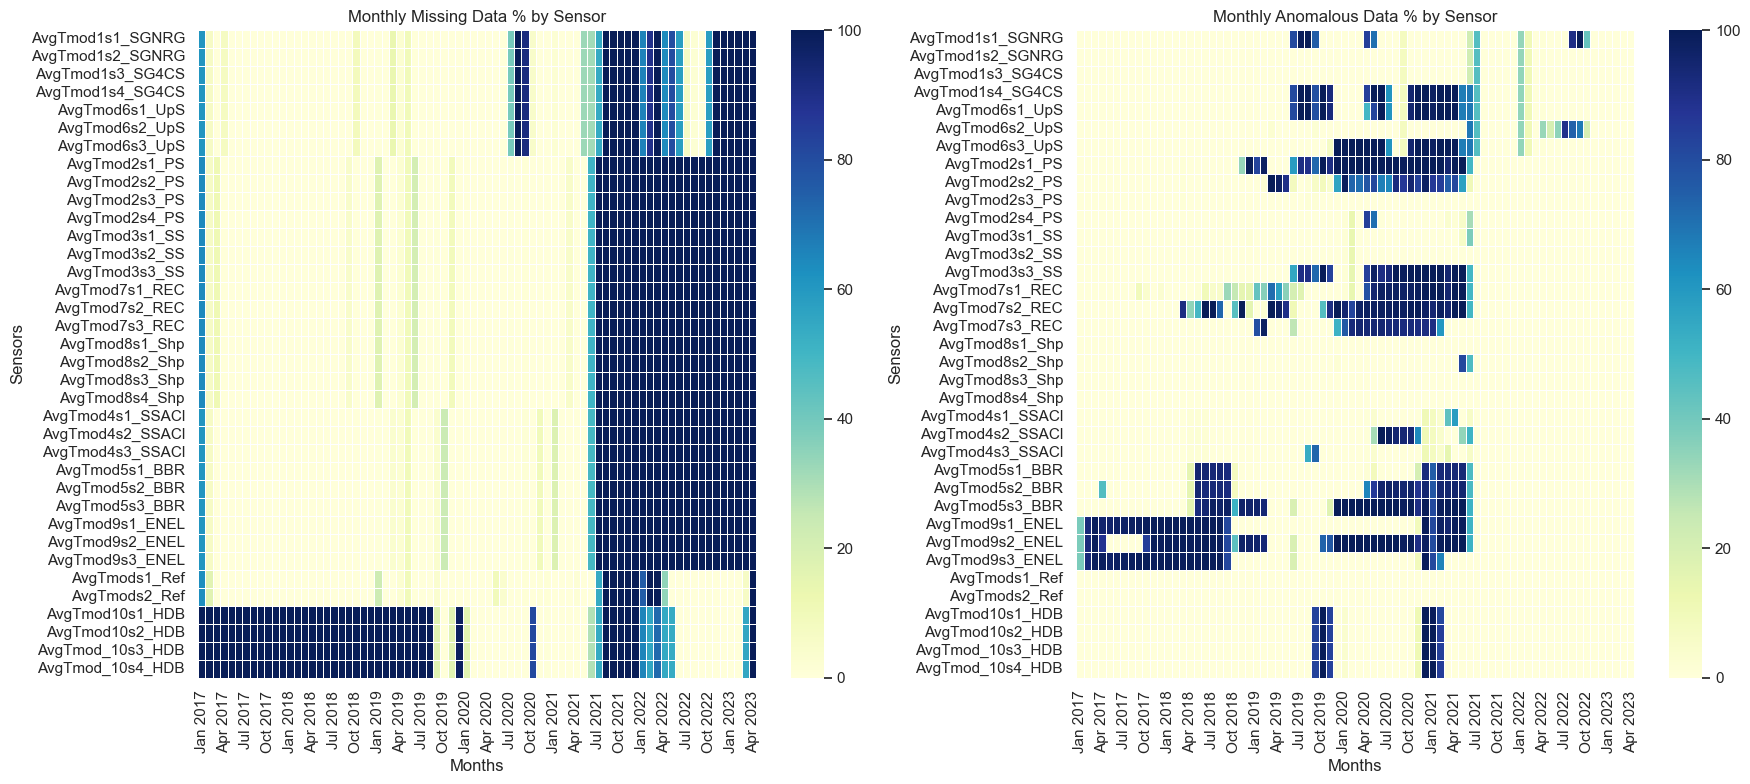

In [33]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# First subplot for NaN percentages
sns.heatmap(nan_df, cmap="YlGnBu", annot=False, fmt=".2f", linewidths=.5, ax=axes[0])
axes[0].set_title('Monthly Missing Data % by Sensor')
axes[0].set_xlabel('Months')
axes[0].set_ylabel('Sensors')

# Second subplot for anomalous percentages
sns.heatmap(anomalous_df, cmap="YlGnBu", annot=False, fmt=".2f", linewidths=.5, ax=axes[1])
axes[1].set_title('Monthly Anomalous Data % by Sensor')
axes[1].set_xlabel('Months')
axes[1].set_ylabel('Sensors')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

Most of the temperature data unfortunately has missing data for April 2021 onwards. There are also some anomalies to filter out.

## Temperature: Filtering

In [34]:
#apply filters

df_Tmod_filtered= df_Tmod.copy()

# Take out anomalous data
df_Tmod_filtered = fl.filter_range(df_Tmod_filtered,range_dict[sensor_type], columns=None)

# Take out abnormal bins - recurring semi-constant erros
df_Tmod_filtered = fl.filter_abnormal_bins(df_Tmod_filtered)

# Take out any months where there is more than 70% NaN data
#df_Tmod_filtered = fl.filter_by_nan_percentage(df_Tmod_filtered, freq='M',threshold=0.7)

# Take out any days where there is more than 70% NaN data
#df_Tmod_filtered = fl.filter_by_nan_percentage(df_Tmod_filtered, freq='D',threshold=0.7)


Number of Deleted Bins:0
Number of Deleted Bins:0
Number of Deleted Bins:0
Number of Deleted Bins:0
Number of Deleted Bins:0
Number of Deleted Bins:0
Number of Deleted Bins:0
Abnormal bin detected in column: AvgTmod2s1_PS
Number of Deleted Bins:1
Number of Deleted Bins:0
Number of Deleted Bins:0
Number of Deleted Bins:0
Number of Deleted Bins:0
Number of Deleted Bins:0
Number of Deleted Bins:0
Number of Deleted Bins:0
Number of Deleted Bins:0
Number of Deleted Bins:0
Number of Deleted Bins:0
Number of Deleted Bins:0
Number of Deleted Bins:0
Number of Deleted Bins:0
Number of Deleted Bins:0
Number of Deleted Bins:0
Number of Deleted Bins:0
Number of Deleted Bins:0
Number of Deleted Bins:0
Number of Deleted Bins:0
Abnormal bin detected in column: AvgTmod9s1_ENEL
Number of Deleted Bins:1
Abnormal bin detected in column: AvgTmod9s2_ENEL
Abnormal bin detected in column: AvgTmod9s2_ENEL
Abnormal bin detected in column: AvgTmod9s2_ENEL
Number of Deleted Bins:3
Abnormal bin detected in column:

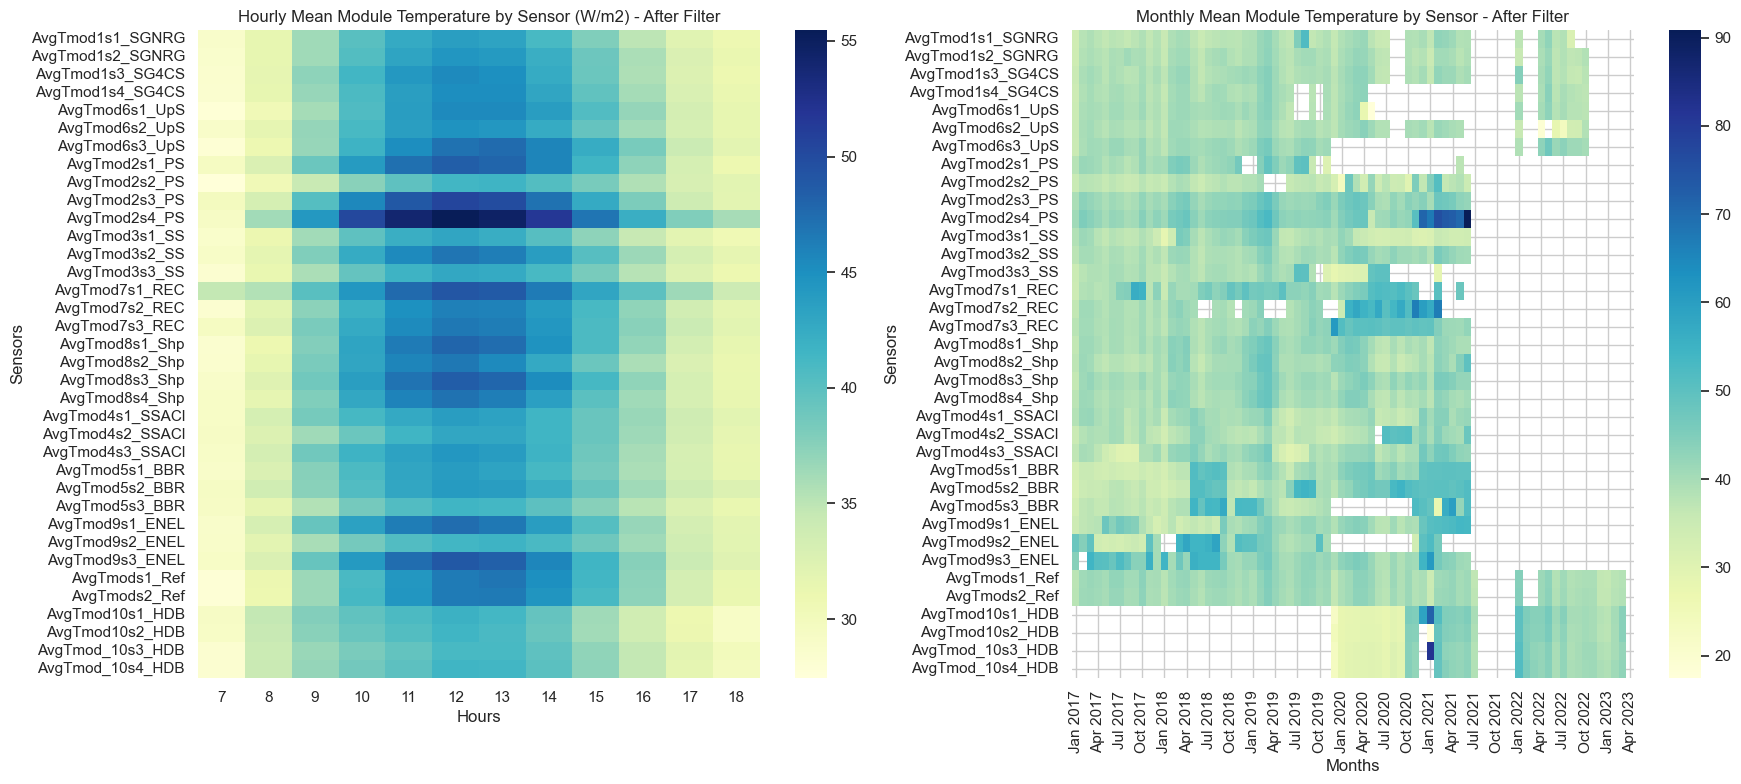

In [35]:
# Create the first heatmap for hourly mean
hourly_mean_df = df_Tmod_filtered.groupby(df_Tmod_filtered.index.hour).mean()

# Create the second heatmap for monthly mean
monthly_mean_df = df_Tmod_filtered.resample('M').mean()
monthly_mean_df.index = monthly_mean_df.index.strftime('%b %Y')

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# First subplot for hourly mean
sns.heatmap(hourly_mean_df.T, cmap="YlGnBu", annot=False, ax=axes[0])
axes[0].set_title('Hourly Mean Module Temperature by Sensor (W/m2) - After Filter')
axes[0].set_xlabel('Hours')
axes[0].set_ylabel('Sensors')

# Second subplot for monthly mean
sns.heatmap(monthly_mean_df.T, cmap="YlGnBu", annot=False, ax=axes[1])
axes[1].set_title('Monthly Mean Module Temperature by Sensor - After Filter')
axes[1].set_xlabel('Months')
axes[1].set_ylabel('Sensors')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# DC Power  <a class="anchor" id="chap_power"></a>

The data will consider the DC power output on a string level. The study will be conducted but on a system-to-system basis, where each system has 4 strings.

The following sections are:

1. Data availability
2. Data quality assessment and grading
3. Data filtering

## DC Power: Data Availability
First, let's visualise the data set to have an idea of it's characteristics. 

In [36]:
sensor_type = 'Pdc'
system_name = 'REC'

In [37]:
# Set toggles
save_raw = False  # Set to True to save raw data, False otherwise
save_filtered = False  # Set to True to save filtered data, False otherwise
visualize = True  # Set to True to visualize data, False otherwise

REC


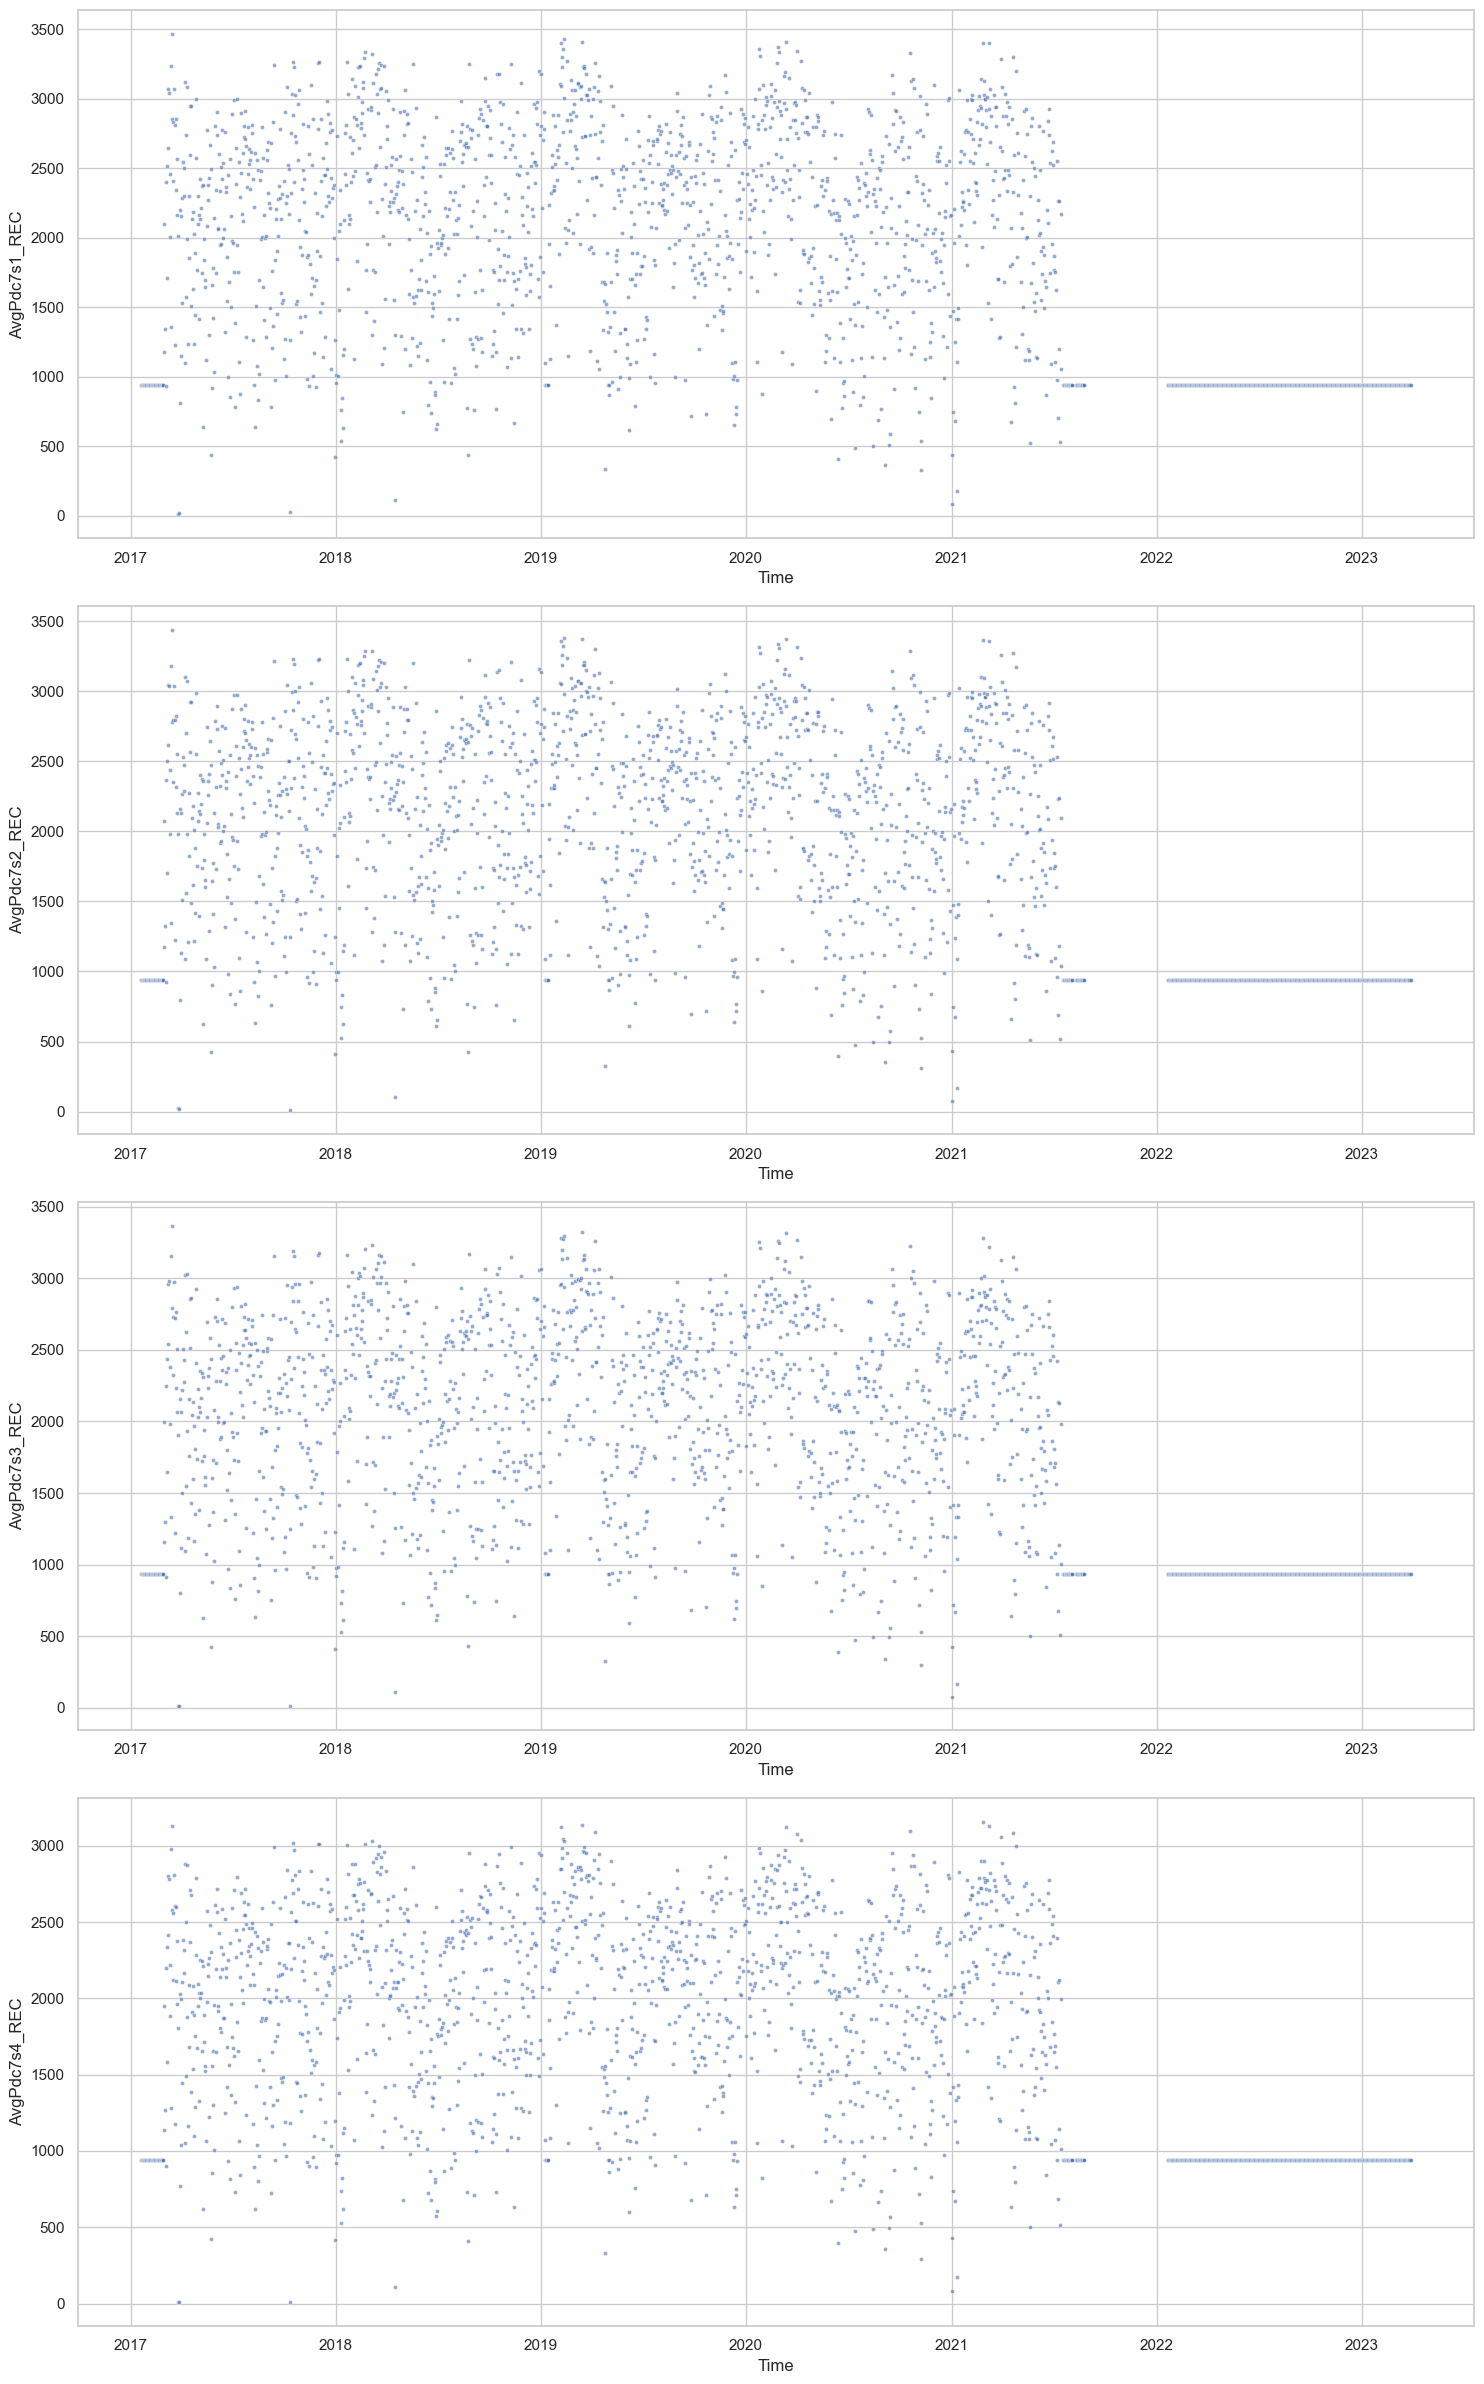

In [38]:
# collect all the sensors with the corresponding sensor type and system_name
sensor_list = fl.filter_sensors_by_terms(sensor_list=sensor_list_all, study_terms=[sensor_type, system_name])

# create a df of sensor data 
df_Pdc_system = fl.generate_sensor_csv(sensor_list, fp_load, sensor_dict, sun_minutes, csv_suffix='_day_merged.csv')

# Toggle: Save Raw Data
if save_raw:
    df_Pdc_system.to_csv(fp_save_raw + system_name + '-' + sensor_type + '_raw.csv')

# Toggle: Visualize Raw Data
if visualize:    
    print(system_name)
    fig_name_raw = fp_fig + system_name + '-' + sensor_type + '-raw.png'
    fl.scatter_plot_and_save(df_Pdc_system, fp_fig, resample_freq='D', fig_name=fig_name_raw)

## DC Power: Data quality assessment and grading

In [39]:
# Create df to store results of data quality grading
results_df_Pdc_system = pd.DataFrame(columns = ['sensor','Outliers (%)','Outliers (%) grade','Missing Percentage (%)','Missing Percentage (%) grade','Longest gap (days)','Longest gap (days) grade','Anomalies (%)','Anomalies (%) grade','Length (days)','Length (days) grade','Grades'])
results_df_Pdc_system['sensor']=sensor_list
results_df_Pdc_system.set_index('sensor',inplace=True)

In [40]:
# grade results
results_df_Pdc_system['Missing Percentage (%)'], results_df_Pdc_system['Missing Percentage (%) grade'] = fl.calculate_missing_percentage_grade(df_Pdc_system)
results_df_Pdc_system['Longest gap (days)'], results_df_Pdc_system['Longest gap (days) grade']= fl.calculate_longest_gap_grade(df_Pdc_system)
results_df_Pdc_system['Outliers (%)'],results_df_Pdc_system['Outliers (%) grade']=fl.calculate_outliers_grade(df_Pdc_system)
results_df_Pdc_system['Anomalies (%)'],results_df_Pdc_system['Anomalies (%) grade']=fl.calculate_anomalies_grade(df_Pdc_system,range_dict['Pdc'])
results_df_Pdc_system['Length (days)'],results_df_Pdc_system['Length (days) grade']=fl.calculate_time_difference_grade(df_Pdc_system)
results_df_Pdc_system['Grades'] = results_df_Pdc_system[['Outliers (%) grade', 'Missing Percentage (%) grade',
                                                                      'Longest gap (days) grade', 'Anomalies (%) grade','Length (days) grade']].apply(lambda x: ''.join(x), axis=1)
results_df_Pdc_system

,Outliers (%),Outliers (%) grade,Missing Percentage (%),Missing Percentage (%) grade,Longest gap (days),Longest gap (days) grade,Anomalies (%),Anomalies (%) grade,Length (days),Length (days) grade,Grades
sensor,,,,,,,,,,,
AvgPdc7s1_REC,0.00,A,9.44,A,61,C,0.66,A,2259,P,AACAP
AvgPdc7s2_REC,0.00,A,9.44,A,61,C,0.73,A,2259,P,AACAP
AvgPdc7s3_REC,0.00,A,9.44,A,61,C,0.69,A,2259,P,AACAP
AvgPdc7s4_REC,0.07,A,9.44,A,61,C,0.71,A,2259,P,AACAP


## DC Power: Filtering

In [41]:
# Set which filters to apply
apply_range_filter = True  # Set to True to apply the range filter, False otherwise
apply_abnormal_bins_filter = True  # Set to True to apply the abnormal bins filter, False otherwise
apply_nan_percentage_filter = True  # Set to True to apply the nan percentage filter, False otherwise

In [42]:
# Apply Filters to df
df_Pdc_system_filtered = df_Pdc_system.copy()  # Initialize with the unfiltered data

# Toggle: Apply Range Filter
if apply_range_filter:
    df_Pdc_system_filtered = fl.filter_range(df_Pdc_system_filtered,range_dict[sensor_type])

# Toggle: Apply Abnormal Bins Filter
if apply_abnormal_bins_filter:
    df_Pdc_system_filtered = fl.filter_abnormal_bins(df_Pdc_system_filtered, n=100)

# Toggle: Apply Nan Percentage Filter
if apply_nan_percentage_filter:
    df_Pdc_system_filtered = fl.filter_by_nan_percentage(df_Pdc_system_filtered,freq='M')


Abnormal bin detected in column: AvgPdc7s1_REC
Number of Deleted Bins:1
Abnormal bin detected in column: AvgPdc7s2_REC
Number of Deleted Bins:1
Abnormal bin detected in column: AvgPdc7s3_REC
Number of Deleted Bins:1
Abnormal bin detected in column: AvgPdc7s4_REC
Number of Deleted Bins:1


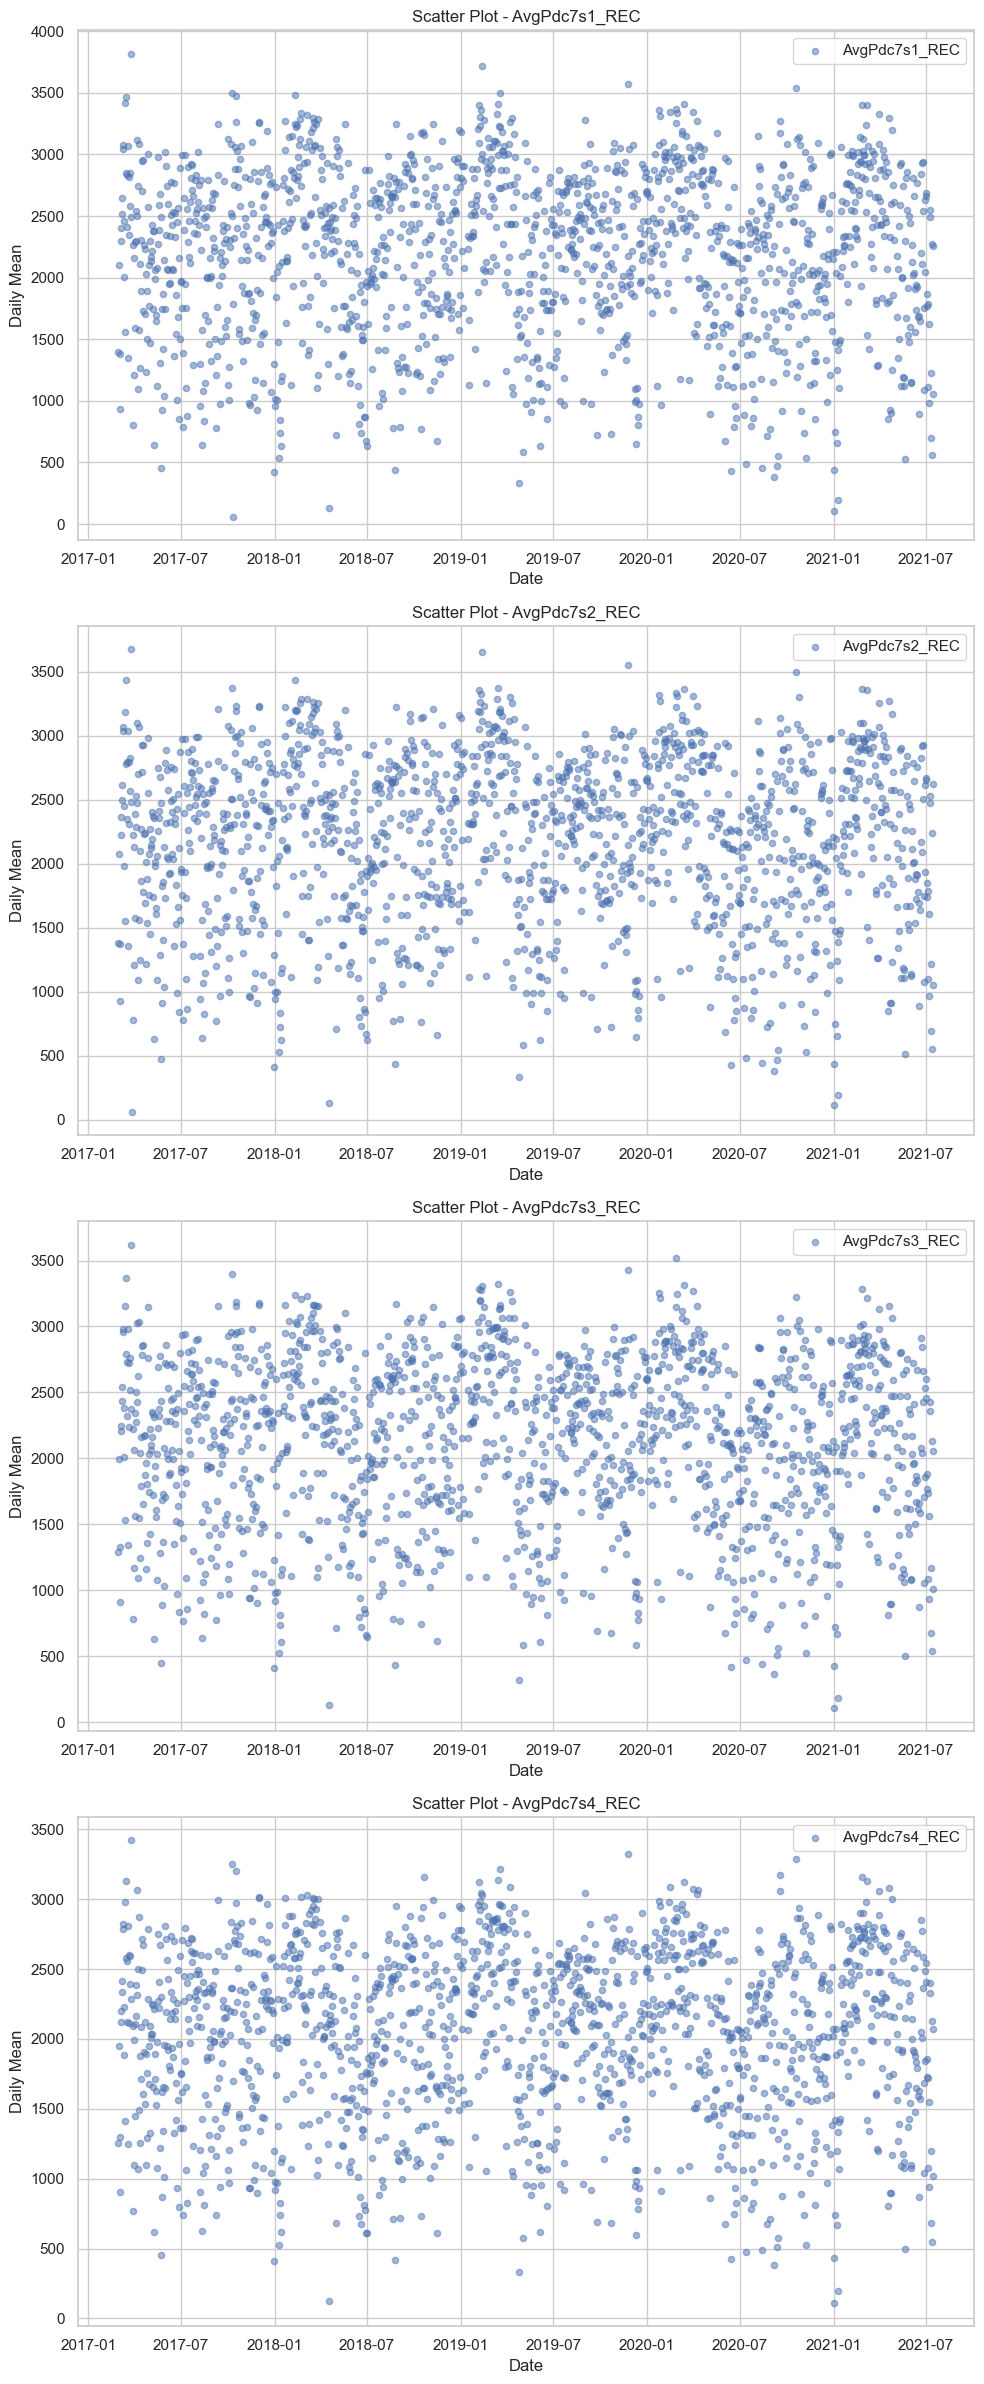

In [43]:
# visualise daily means
daily_mean = df_Pdc_system_filtered.resample('D').mean()

# Create a scatter plot for each column
fig, axes = plt.subplots(nrows=len(daily_mean.columns), figsize=(10, 6 * len(daily_mean.columns)))

for i, column in enumerate(daily_mean.columns):
    axes[i].scatter(daily_mean.index, daily_mean[column], label=column, s=20, alpha=0.5)

    # Add labels and title
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Daily Mean')
    axes[i].set_title(f'Scatter Plot - {column}')

    # Add legend
    axes[i].legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


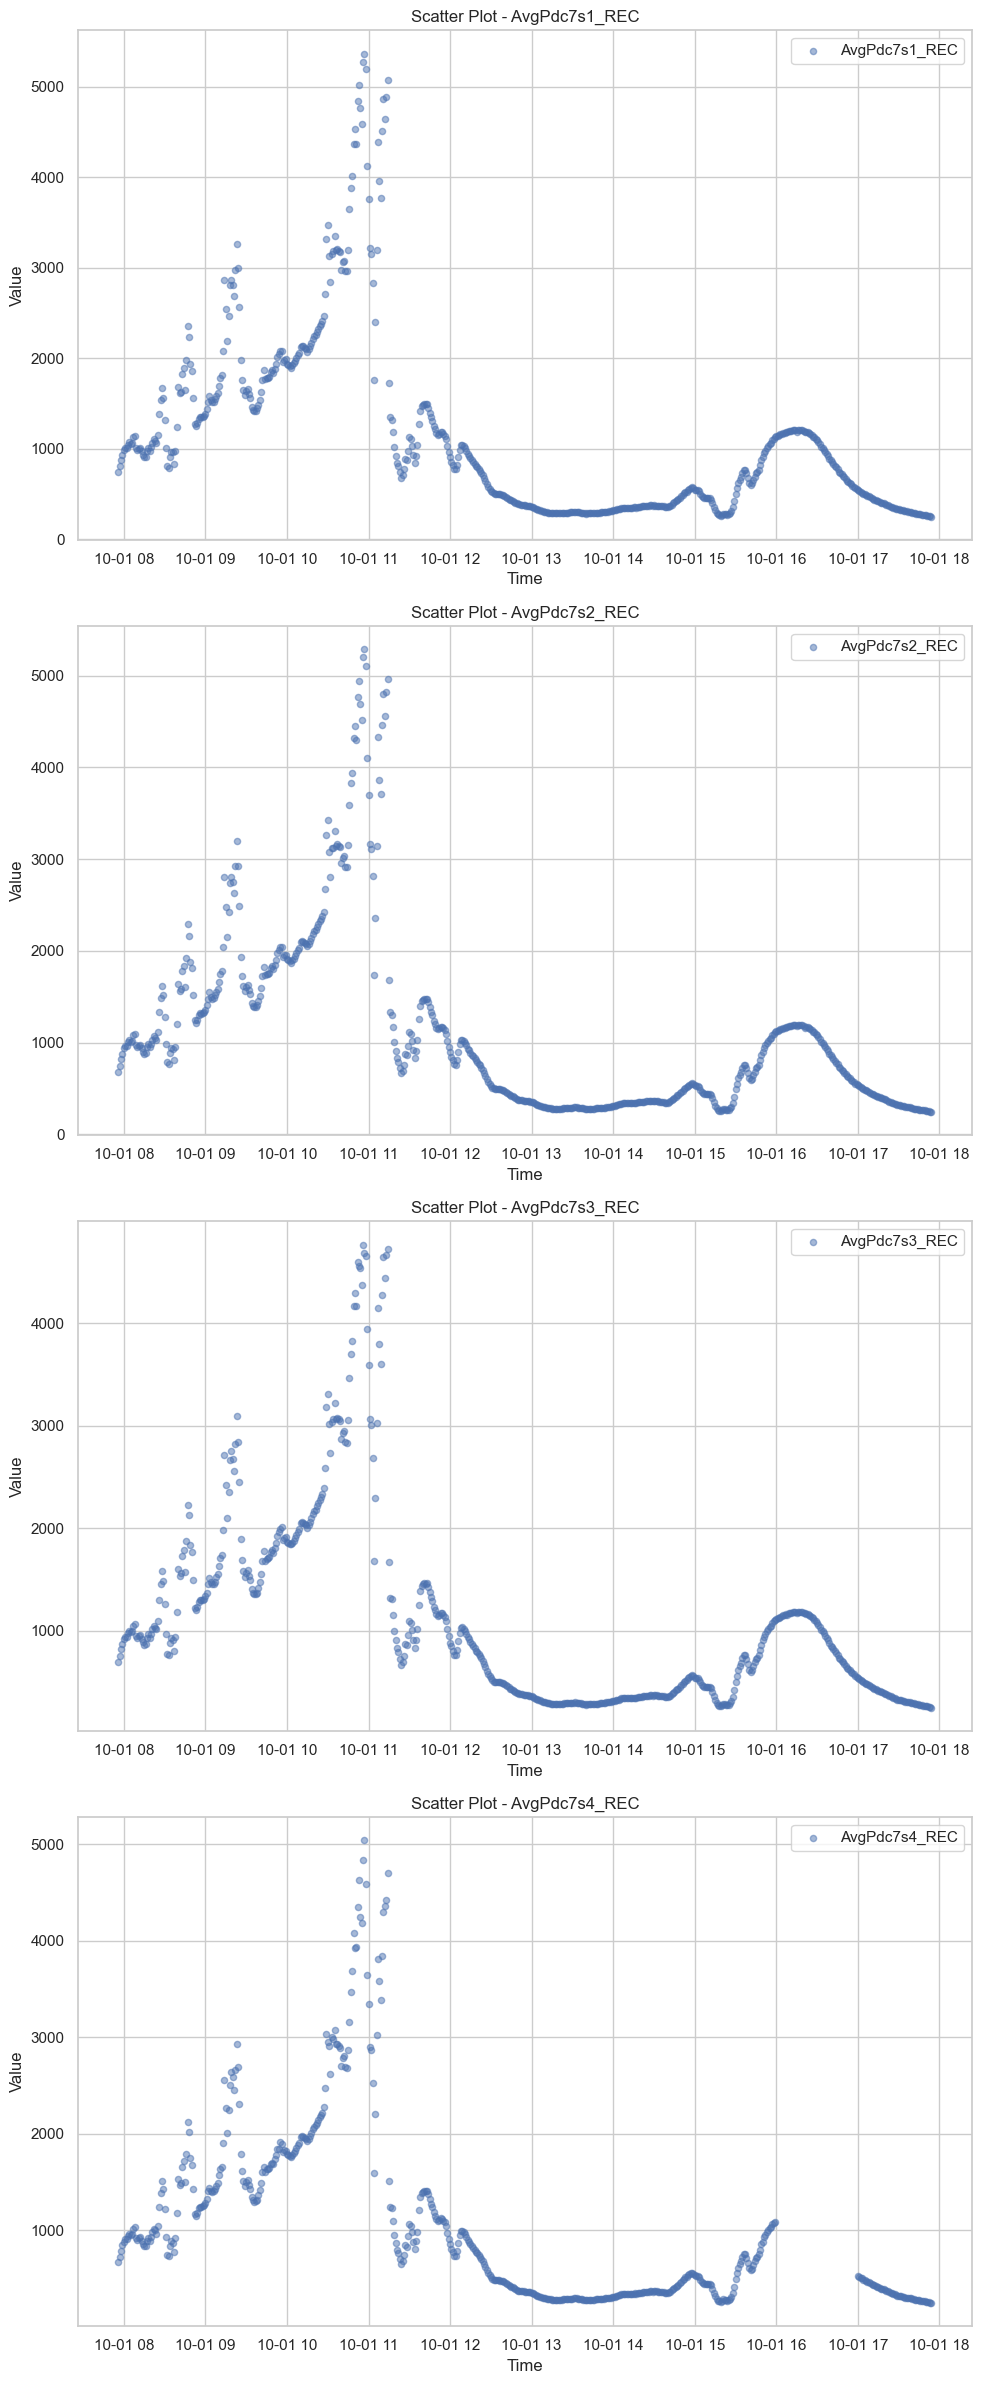

In [44]:
# Visualise power on a specific day
selected_day = '2017-10-01'

# Filter data for the selected day
selected_data = df_Pdc_system_filtered[df_Pdc_system_filtered.index.date == pd.to_datetime(selected_day).date()]

# Create a scatter plot for each column
fig, axes = plt.subplots(nrows=len(selected_data.columns), figsize=(10, 6 * len(selected_data.columns)))

for i, column in enumerate(selected_data.columns):
    axes[i].scatter(selected_data.index, selected_data[column], label=column, s=20, alpha=0.5)

    # Add labels and title
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Value')
    axes[i].set_title(f'Scatter Plot - {column}')

    # Add legend
    axes[i].legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [45]:
# Toggle: Save Filtered Data
if save_filtered:
    df_system_filtered.to_csv(fp_save_filtered + system_name + '-' + sensor_type + '_filtered.csv')

# Toggle: Visualize Filtered Data (Scatter Plot)
if visualize:
    fig_name_filtered = fp_fig + system_name + '-' + sensor_type + '-filtered.png'
    scatter_plot_and_save(df_system_filtered, fp_fig, resample_freq='D', fig_name=fig_name_filtered)

    fig_name_compare_histograms = fp_fig + system_name + '-' + sensor_type + '-compare_histograms.png'
    compare_histograms(df_system, df_system_filtered, bins=100, fig_name=fig_name_compare_histograms)

    fig_name_nan_distribution = fp_fig + system_name + '-' + sensor_type + '-nan_distribution.png'
    plot_nan_percentage_heatmap(df_system_filtered, fig_name=fig_name_nan_distribution)

NameError: name 'scatter_plot_and_save' is not defined

## DC Power: Temperature Correction

$P_{corr} = \frac{G_{POA}}{1000*P_0}(1+\gamma_{P_mp}(T_{m}-25))$

# Performance Ratio  <a class="anchor" id="chap_PR"></a>

The Performance Ratio (PR) is a performance metric that compares the PV system to its STC rating.

$PR_{DC} = \frac{P_{DC}/P_{STC}}{G_{mod}/G_{STC}}$

In [ ]:
# System specs
system_strings = df_Pdc_system_filtered.columns
system = 'REC'

P_stc_panel = float(module_Wp_d[system])
n_panel = float(no_of_panels_d[system])
G_stc = float(1000)

In [ ]:
#calculate time-aggregated  PR 

# declare df for PR
df_PRs_agg = []
df_PR = pd.DataFrame()

# toggle IQR filter
IQR_filter = True

# choose time aggregate : 'D' for daily, 'M' for monthly and 'H' for hour
time_aggregate = 'M' 

# iterate to each string in system
for string in system_strings:
    df_calc_PR = pd.concat([df_Gmod_calc,df_Pdc_system_filtered[string]],axis=1)
    df_calc_PR = df_calc_PR.dropna(axis=0, how='any') #delete any rows with nan
    df_calc_PR = df_calc_PR.drop(df_calc_PR[df_calc_PR.eq(0).any(axis=1)].index)
    
    # apply IQR filter to PR
    if IQR_filter:
        Q1 = df_calc_PR.quantile(0.25)
        Q3 = df_calc_PR.quantile(0.75)
        IQR = Q3 - Q1
        df_calc_PR = df_calc_PR[~((df_calc_PR < (Q1 - 1.5 * IQR)) | (df_calc_PR > (Q3 + 1.5 * IQR))).any(axis=1)]

    df_calc_PR_agg = df_calc_PR.resample(time_aggregate).sum()
    df_calc_PR_agg = df_calc_PR_agg.dropna(axis=0, how='any') 
    df_PR_agg =  (df_calc_PR_agg[string] * G_stc) / (df_calc_PR_agg[gmod_col]*n_panel*P_stc_panel)
    df_PR_agg = df_PR_agg.resample(time_aggregate).mean()
    df_PR_agg.name = string.replace("Pdc", "PR")
    df_PRs_agg.append(df_PR_agg) 

df_PR_agg = pd.concat(df_PRs_agg, axis = 1)

In [ ]:
df_PR

*Visualising the PR of the system*

In [ ]:
# Create subplots for each column
fig, axes = plt.subplots(nrows=len(df_PR_agg.columns), figsize=(10, 6 * len(df_PR_agg.columns)))

# Iterate through each column
for i, column in enumerate(df_PR_agg.columns):
    # Create a scatter plot for the column
    axes[i].scatter(df_PR_agg.index, df_PR_agg[column], label=column, s=20, alpha=0.5)

    # Add labels and title
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel(f'{column} Performance Ratio')

    # Add legend
    axes[i].legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# PLR

## PLR: Linear Regression

## STL: Seasonal Trend Decomposition

In [ ]:

# Perform seasonal trend decomposition using LOESS (STL)
res = sm.tsa.seasonal_decompose(df_monthly_pr, period=12, model='multiplicative', extrapolate_trend='freq')

# Extract the trend component
trend = res.trend.dropna()

# Calculate PLR as the relative change in trend
plr = (trend.iloc[-1] / trend.iloc[0]) - 1

# Plot the original data, trend, and PLR
fig, ax = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

df_monthly_pr.plot(ax=ax[0], title='Original Data')
trend.plot(ax=ax[1], title='Trend Component')
plr.plot(ax=ax[2], kind='bar', title='Performance Loss Rate (PLR)')

plt.tight_layout()
plt.show()

## YoY: Year-on-Year

This approach was initially employed for the determination of Performance Loss Ratio (PLR) by Hasselbrink and has been widely adopted, being incorporated into both the Python RdTools package and the PVplr R package. It relies on a loss rate distribution rather than a singular value. In this method, a performance metric datapoint (resolution depends on the selected aggregation step, which can span hours, days, weeks, or months) in one calendar year is compared to the corresponding value at the same time in the subsequent year, and the gradient is recorded. This process is repeated across all available datapoints and years, and the median of the gradients determines the PLR. The PLR computed using the Year-over-Year (YoY) method is typically normalized to the first-year's median [4, 39]
(Lindig et al., 2022, p. 10) (pdf).







In [ ]:
# Calculate the degradation rate using the YoY method
yoy_rd, yoy_ci, yoy_info = rdtools.degradation_year_on_year(daily, confidence_level=68.2)
# Note the default confidence_level of 68.2 is appropriate if you would like to
# report a confidence interval analogous to the standard deviation of a normal
# distribution. The size of the confidence interval is adjustable by setting the
# confidence_level variable.

# Visualize the results

degradation_fig = rdtools.degradation_summary_plots(
    yoy_rd, yoy_ci, yoy_info, daily,
    summary_title='Sensor-based degradation results',
    scatter_ymin=0.5, scatter_ymax=1.1,
    hist_xmin=-30, hist_xmax=45, bins=100
)
